### Wstęp do Uczenia Maszynowego 
##### Laboratorium 09

### 1. Przygotowanie danych

a ) wartości odstające

- boxplot/histogram
- wartości poniżej/powyżej rozkładu 3 $\sigma$


b) braki danych

- imputacja poprzez średnią lub częstość (zależne od typu zmiennej)
- wytrenowanie modelu do uzupełniania braków danych

### 2. Pipeline (scikit-learn)

<img src="pipeline.png" alt="drawing" width="600"/>

*https://medium.com/ai-made-simple/pipelines-in-scikit-learn-46c61c5c60b2*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv("titanic.csv")
y = df.survived 
X = df.drop(["survived"], axis = 1)

### Zadanie 1
-----
Przyjrzyj się danym `titanic`. Czy są wymagają jakiegoś wstępnego przygotowania?

In [12]:
# Sporóbujmy podzielić kolumny w zbiorze danych na 3 kategorie:
# - są OK
# - potrzebują poprawy
# - są zbędne

In [ ]:
X.info()
# część kolumn zawiera braki danych, zastanówmy się, które z nich warto uzupełniać a które wyrzucić
# pclass - brak braków danych, wpływa na przeżycie, zmienne ważna - zostawić
# name - imiona i nazwiska pasażerów - nie wpływa na przeżycie - usunąć
# sex - płeć, brak braków danych - wpływa na przeżycie - zostawić
# age - brak ~250 obserwacji - raczej warto uzupełnić
# sibsp, parch - liczba osób nieletnich/dorosłych podróżujących z danym pasażerem
# ticket - numer biletu - nie wpływa na przeżycie - usunąć
# fare - opłata za bilet - jeden brak danych - można zostawić
# cabin - numer kabiny - raczej nie warto uzupełniać
# boat - numer łódki - informacja, która dotyczy raczej tylko tych co przeżyli - lepiej pominąć
# body - bardzo dużo braków danych - lepiej pominąć
# embarked - miejsce wejścia na pokład - nie daje informacji - można pominąć
# home.dest - miejsce docelowe - nie daje informacji - można pominąć

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   float64
 1   name       1309 non-null   object 
 2   sex        1309 non-null   object 
 3   age        1046 non-null   float64
 4   sibsp      1309 non-null   float64
 5   parch      1309 non-null   float64
 6   ticket     1309 non-null   object 
 7   fare       1308 non-null   float64
 8   cabin      295 non-null    object 
 9   embarked   1307 non-null   object 
 10  boat       486 non-null    object 
 11  body       121 non-null    float64
 12  home.dest  745 non-null    object 
dtypes: float64(6), object(7)
memory usage: 133.1+ KB


<Axes: >

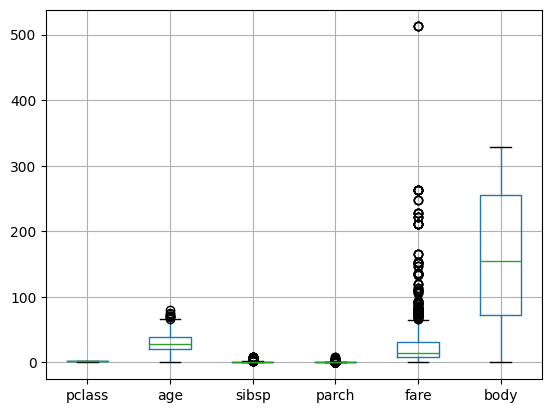

In [3]:
# rozkład zmiennych numerycznych (ilościowych)
X.boxplot()

In [4]:
X.describe()

,pclass,age,sibsp,parch,fare,body
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [ ]:
# - są OK
# pclass, sex, sibsp, parch
# - potrzebują poprawy
# age, fare
# - są zbędne
# name, ticket, cabin, boat, body, embarked, home.dest

In [6]:
X = X.drop(["name", "ticket", "cabin", "boat", "body", "embarked", "home.dest"], axis=1)

### Zadanie 2
-----
Przygotuj wektor `numerical_features` i `categorical_features`, które będą odpowiednio zawierały nazwy kolumn numerycznych i kategorycznych.

In [ ]:
# Definicja list z nazwami kolumn dla zmiennych numerycznych i kategorycznych
numerical_features = ['pclass', 'age', 'sibsp', 'parch', 'fare']
categorical_features = ['sex']

numerical_features = list(X.dtypes[(X.dtypes != 'object') & (X.dtypes != 'category')].index)
categorical_features = list(X.dtypes[(X.dtypes == 'object') | (X.dtypes == 'category')].index)

print('Numerical features:', numerical_features)
print('Categorical features:', categorical_features)

Numerical features: ['pclass', 'age', 'sibsp', 'parch', 'fare']
Categorical features: ['sex']


----

In [9]:
# pipeline dla zmiennych numerycznych
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
])

### Zadanie 3
-----
Przygotuj `pipeline` dla zmiennych kategorycznych. 
Użyj `SimpleImputer()` o startegii wyboru najczęstszej kategorii.
Użyj `OneHotEncoder()` o strategii 'ignore' dla argumentu 'handle_unknown'.

In [10]:
# pipeline dla zmiennych kategorycznych
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

------
#### Column Transformer + Model

In [11]:
# połączenie pipelinów do przetworzenia danych
preprocessor = ColumnTransformer([
    ('numerical', numerical_transformer, numerical_features),
    ('categorical', categorical_transformer, categorical_features)
])

In [12]:
# pipeline z dołożonym modelem drzewa
pipeline = Pipeline([
    ('pre', preprocessor),
    ('tree', DecisionTreeClassifier())
])

In [13]:
pipeline

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['pclass', 'age', 'sibsp',
                                                   'parch', 'fare']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex'])])),
                ('tree', DecisionTreeClassifier())])

In [14]:
# podział na zbiór treningowy i testowy, trenowanie modelu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
pipeline.fit(X_train, y_train)

print('Training set accuracy:', np.round(pipeline.score(X_train, y_train), 4))
print('Test set accuracy:' , np.round(pipeline.score(X_test, y_test), 4))

Training set accuracy: 0.9694
Test set accuracy: 0.7519


*Note:* Model przeuczony na zbiorze treningowym, warto rozważyć optymalizację hiperparametrów.

### Zadanie 4
-----
Wczytaj zbiór danych `pima.csv`. Przyjrzyj się się zmiennej `BloodPressure`. Narysuj jej rozkład względem y.

In [46]:
pima = pd.read_csv("pima.csv")

In [47]:
y = pima.Outcome
X = pima.drop(["Outcome"], axis = 1)

In [ ]:
# rozkład zmiennej BloodPressure 
sns.histplot(x = 'BloodPressure', hue = 'Outcome', data = pima)

### Zadanie 5
-----
a) Zastąp wartości 0 zmiennej `BloodPressure` jako braki danych. Podziel dane na zbiór treningowy i testowy w proporcji 7:3. Następnie przygotuj `pipeline`, który będzie składał się z metody imputacji danych poprzez średnią z pozostałych obserwacji. Kolejnym elementem `pipeline` będzie stworzenie modelu drzewa. Wylicz miarę `accuracy` na zbiorze treningowym i testowym.

b) Do `pipeline` dodajmy optymalizację parametrów używając `GridSearch` z 3-krotną krowswalidacją. Rozważmy poszczególne parametry i ich wartości:
- maksymalna głębokość [5, 6, ..., 12]
- minimalna liczba obserwacji w liściu [3, 4, ..., 9]

c) Jakie parametry okazały się optymalne? Wylicz miarę dokładności oraz ROC AUC. Porównaj wyniki dla optymalnych parametrów z bazowym modelem drzewa.

In [ ]:
# a) zamiana 0 na braki danych
X.BloodPressure[X.BloodPressure == 0] = np.nan

In [50]:
pipeline = Pipeline([
    ('imputation', SimpleImputer(strategy = 'mean')),
    ('tree', DecisionTreeClassifier())
])

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [52]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputation', SimpleImputer()),
                ('tree', DecisionTreeClassifier())])

In [53]:
train_score = pipeline.score(X_train, y_train)
print('Accuracy score on the training set:', np.round(train_score, 5))

test_score = pipeline.score(X_test, y_test)
print('Accuracy score on the training set:', np.round(test_score, 5))


Accuracy score on the training set: 1.0
Accuracy score on the training set: 0.69264


In [54]:
# b) dodanie grid search - optymalizacja HPO
params = { 
    'tree__max_depth': [5, 6, 7, 8, 9, 10, 11, 12],
    'tree__min_samples_leaf': [3, 4, 5, 6, 7, 8, 9]
}

# kroswalidacja
grid_pipeline = GridSearchCV(pipeline,
                             cv = 3,
                             param_grid = params)

In [55]:
# trenowanie modelu
grid_pipeline.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('imputation', SimpleImputer()),
                                       ('tree', DecisionTreeClassifier())]),
             param_grid={'tree__max_depth': [5, 6, 7, 8, 9, 10, 11, 12],
                         'tree__min_samples_leaf': [3, 4, 5, 6, 7, 8, 9]})

In [56]:
# najlepsze hiperparametry
grid_pipeline.best_params_

{'tree__max_depth': 5, 'tree__min_samples_leaf': 6}

In [57]:
test_acc = grid_pipeline.score(X_test, y_test)
print('Accuracy score on the test set:', np.round(test_acc, 5))

test_auc = roc_auc_score(y_test, grid_pipeline.predict_proba(X_test)[:,1])
print('Accuracy score on the test set:', np.round(test_auc, 5))

Accuracy score on the test set: 0.7316
Accuracy score on the test set: 0.74992


In [58]:
# Model drzewa o parametrach domyślnych
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [59]:
test_acc = tree.score(X_test, y_test)
print('Accuracy score on the test set:', np.round(test_acc, 5))

test_auc = roc_auc_score(y_test, tree.predict_proba(X_test)[:,1])
print('Accuracy score on the test set:', np.round(test_auc, 5))

Accuracy score on the test set: 0.69697
Accuracy score on the test set: 0.66019
